In [1]:
import pandas as pd
import re
from pykospacing import Spacing

In [2]:
import os
os.getcwd()

'/Users/ryleyun/Desktop/Github/Ryles_Practice/Paperstudy'

train = open('../DATA/cnnpaper/ratings_train.txt', 'r')
train = train.readlines()
test = open('../DATA/cnnpaper/ratings_test.txt', 'r')
test = test.readlines()

train = [line.strip().split('\t') for line in train]
test = [line.strip().split('\t') for line in test]

train_df = pd.DataFrame(train[1:], columns=train[0])
test_df = pd.DataFrame(test[1:], columns=test[0])

spacing = Spacing()
train_df['document'] = [spacing(str(sent)) for sent in train_df['document']]
test_df['document'] = [spacing(str(sent)) for sent in test_df['document']]

train_df.to_csv('train_spacing.csv')
test_df.to_csv('test_spacing.csv')

In [3]:
train_df = pd.read_csv('../DATA/train_spacing.csv')
test_df = pd.read_csv('../DATA/test_spacing.csv')

In [32]:
from konlpy.tag import Mecab
mecab = Mecab()

In [33]:
%%time
def pos(x):
    try:
        text = ''
        for word, pos in mecab.pos(str(x)):
            if pos[0] not in ['J','I','E']:
                if type(re.search("\W+|[0-9]", word))!=re.Match: 
                    # and len(word)!=1:
                    text+=" "+word
        return text.strip()
    
    except:
        pass

train_df["pos"] = train_df["document"].apply(pos)
test_df["pos"] = test_df["document"].apply(pos)

CPU times: user 11.9 s, sys: 35.1 ms, total: 11.9 s
Wall time: 11.9 s


In [34]:
vocab_size = [] 

for line in train_df['pos']:
    vocab_size.extend(str(line).split())
len(set(vocab_size))

46941

(array([3.0141e+04, 1.3184e+04, 3.5000e+03, 1.8090e+03, 1.2780e+03,
        8.4000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
         94.5, 105. ]),
 <BarContainer object of 10 artists>)

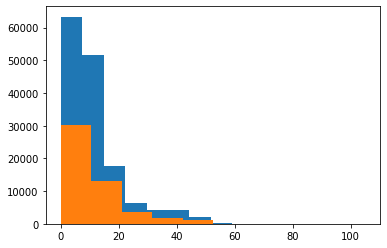

In [35]:
train_length = [len(str(line).split()) for line in train_df['pos']]
test_length = [len(str(line).split()) for line in test_df['pos']]

import matplotlib.pyplot as plt
plt.hist(train_length)
plt.hist(test_length)

In [36]:
# tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_df['pos'])
word_index = tokenizer.word_index

# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = tokenizer.texts_to_sequences(train_df['pos'])
test_seq = tokenizer.texts_to_sequences(test_df['pos'])
train_pad = pad_sequences(train_seq, maxlen=40, padding='post', truncating='post')
test_pad = pad_sequences(test_seq, maxlen=40, padding='post', truncating='post')

In [37]:
test_pad.shape

(50000, 40)

In [46]:
embedding_dim = 20
max_length = 40
vocab_size = len(set(word_index))+1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras import layers, models

model = Sequential()
# Embedding layer? Input 값이 처음으로 들어오는 layer
# vocab_size는 데이터 셋 내의 유니크 단어 수, embedding_dim은 몇 차원으로 줄일 것인지, input_length는 들어오는 문장의 최대 길이
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 3, activation='relu', padding='Same'))
model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu', padding='Same'))
model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 20)            928480    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 40, 128)           7808      
_________________________________________________________________
dropout_19 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 20, 256)           98560     
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 10, 256)          

In [48]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(train_pad, train_df['label'].astype('int32'), epochs=10, batch_size=300, validation_split=0.2, verbose=2)

Epoch 1/10
400/400 - 22s - loss: 0.5542 - accuracy: 0.6891 - val_loss: 0.3925 - val_accuracy: 0.8323
Epoch 2/10
400/400 - 21s - loss: 0.3768 - accuracy: 0.8478 - val_loss: 0.3539 - val_accuracy: 0.8459
Epoch 3/10
400/400 - 21s - loss: 0.3246 - accuracy: 0.8751 - val_loss: 0.3471 - val_accuracy: 0.8492
Epoch 4/10
400/400 - 21s - loss: 0.2861 - accuracy: 0.8918 - val_loss: 0.3541 - val_accuracy: 0.8506
Epoch 5/10
400/400 - 21s - loss: 0.2525 - accuracy: 0.9064 - val_loss: 0.3572 - val_accuracy: 0.8494
Epoch 6/10
400/400 - 21s - loss: 0.2265 - accuracy: 0.9166 - val_loss: 0.3672 - val_accuracy: 0.8468
Epoch 7/10
400/400 - 21s - loss: 0.2058 - accuracy: 0.9254 - val_loss: 0.4041 - val_accuracy: 0.8438
Epoch 8/10
400/400 - 21s - loss: 0.1859 - accuracy: 0.9330 - val_loss: 0.4829 - val_accuracy: 0.8364
Epoch 9/10
400/400 - 21s - loss: 0.1710 - accuracy: 0.9390 - val_loss: 0.4377 - val_accuracy: 0.8403
Epoch 10/10
400/400 - 21s - loss: 0.1602 - accuracy: 0.9420 - val_loss: 0.5299 - val_accura

In [50]:
pred = model.predict(test_pad)

In [54]:
result = []
for i in pred:
    if i>=0.5:
        result.append(1)
    else:
        result.append(0)

In [59]:
sum(result==test_df['label'])/len(test_df)

0.83144